# Compute seasonal net outgassing

Start with [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like [util.py](util.py).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import util

## Connect to catalog

This notebook uses an [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to describe file locations. This is the basis of [intake-esm](https://intake-esm.readthedocs.io/en/latest/), though here we are not using `intake-esm` directly.

In [3]:
%%time
df = pd.read_csv(util.catalog_json)
df

CPU times: user 5.37 s, sys: 517 ms, total: 5.88 s
Wall time: 5.96 s


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r3i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
...,...,...,...,...,...,...,...,...,...,...,...,...
1850252,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,209901010600-210001010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850253,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,210001010600-210101010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850254,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20150101-20491230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850255,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20500101-20991230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...


## Specify a subset of models

In [4]:
models = [
    'CanESM5', 'CanESM5-CanOE', 'CNRM-ESM2-1', 'ACCESS-ESM1-5',
    'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-M.MPI-ESM1-2-HR'
]

## Get grid data from each model

Skip models where the grid data is not available

In [5]:
dsets_fix = {}
grid_variables = ['areacello',]
for model in models:
    dsets_m = [util.get_gridvar(df, model, v) for v in grid_variables]
    dsets_m = [ds for ds in dsets_m if ds is not None]
    if dsets_m:
        dsets_fix[model] = xr.merge(dsets_m)
        dsets_fix[model].attrs['source_id'] = model
        
list(dsets_fix.keys())

MPI-M.MPI-ESM1-2-HR: missing "areacello"


['CanESM5',
 'CanESM5-CanOE',
 'CNRM-ESM2-1',
 'ACCESS-ESM1-5',
 'MPI-ESM-1-2-HAM',
 'IPSL-CM6A-LR']

## Compute a region mask for integration

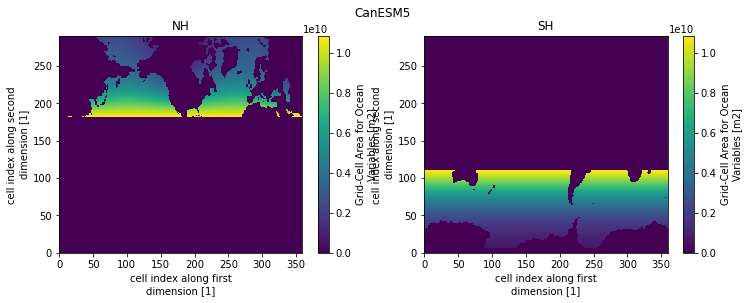

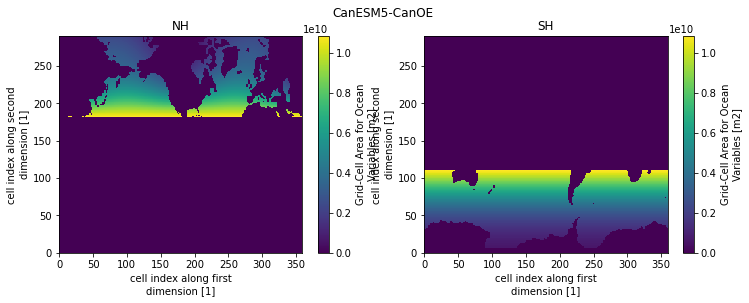

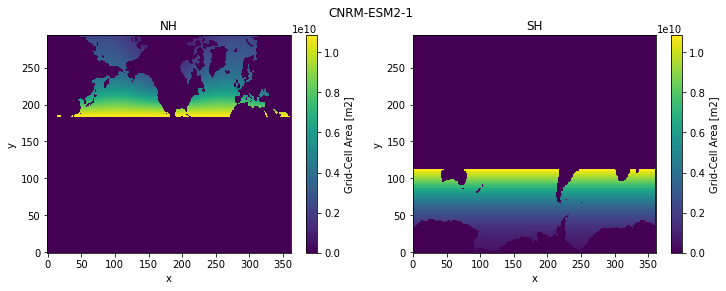

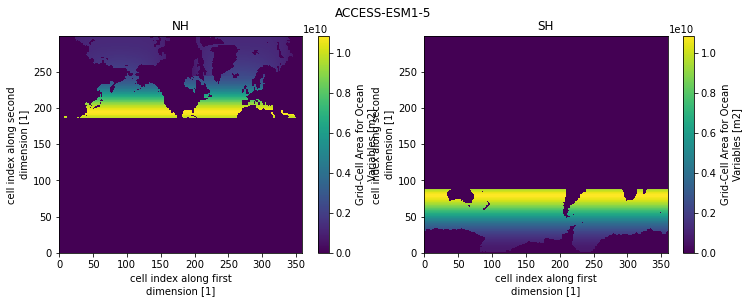

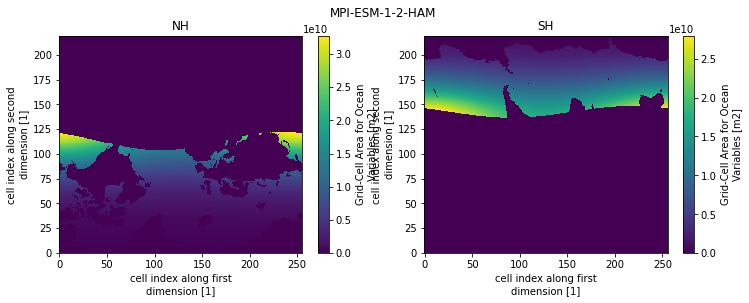

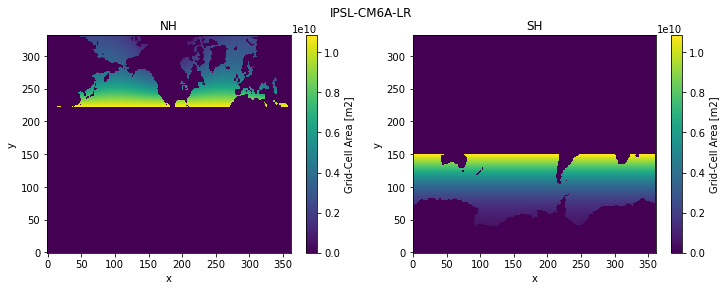

In [6]:
rmask_definition = 'SH_NH'

rmask_dict = {}
for model in models:    
    if model not in dsets_fix:
        continue
    rmask_dict[model] = util.get_rmask_dict(
        dsets_fix[model], 
        mask_definition=rmask_definition, 
        plot=True
    )    

## Assemble monthly-mean climatology

This code takes the following steps:
- Read a dataset for each model
- Compute the regional integral 
- Compute the mean for each month and average across ensemble members
- Concatenate the resulting timeseries along a `source_id` dimension

Note that the code is set up to cache the resulting dataset; it will optionally read this dataset, rather than recreate it, if it exists.

In [10]:
%%time

variable_id = 'fgo2'
time_slice = slice('1980', '2010')
experiment_id = 'historical' 
nmax_members = 4
clobber = False

cache_file = f'data/cmip6_{experiment_id}.{variable_id}.{rmask_definition}.monclim.{time_slice.start}-{time_slice.stop}.zarr'
if os.path.exists(cache_file) and not clobber:
    ds = xr.open_zarr(cache_file)

else:
    da_list = []
    model_list = []
    for source_id in models:    
        if source_id not in rmask_dict:
            continue

        dsi = util.open_cmip_dataset(
            df=df,
            source_id=source_id, 
            variable_id=variable_id, 
            experiment_id=experiment_id, 
            time_slice=time_slice, 
            nmax_members=nmax_members,
        )
        if dsi is None:
            continue

        da = util.compute_regional_integral(dsi, variable_id, rmask_dict[source_id])    
        with xr.set_options(keep_attrs=True):
            da = da.groupby('time.month').mean().mean('member_id')

        da_list.append(da)
        model_list.append(source_id)

    ds = xr.concat(da_list, dim=xr.DataArray(model_list, dims=('source_id'), name='source_id'))
    ds = ds.to_dataset().drop(['depth']).compute()
    ds.to_zarr(cache_file, mode='w');

CanESM5, historical, fgo2
	found 50 ensemble members
	reading 4 members: ['r10i1p1f1', 'r10i1p2f1', 'r11i1p1f1', 'r11i1p2f1']

CanESM5-CanOE, historical, fgo2
no data
CNRM-ESM2-1, historical, fgo2
	found 10 ensemble members
	reading 4 members: ['r10i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2']

ACCESS-ESM1-5, historical, fgo2
	found 3 ensemble members
	reading 3 members: ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']

MPI-ESM-1-2-HAM, historical, fgo2
	found 2 ensemble members
	reading 2 members: ['r1i1p1f1', 'r2i1p1f1']

IPSL-CM6A-LR, historical, fgo2
	found 32 ensemble members
	reading 4 members: ['r10i1p1f1', 'r11i1p1f1', 'r12i1p1f1', 'r13i1p1f1']

CPU times: user 19.9 s, sys: 8.05 s, total: 27.9 s
Wall time: 41.4 s


In [11]:
ds.info()

xarray.Dataset {
dimensions:
	month = 12 ;
	region = 2 ;
	source_id = 5 ;

variables:
	<U2 region(region) ;
	int64 month(month) ;
	<U15 source_id(source_id) ;
	float32 fgo2(source_id, region, month) ;
		fgo2:units = Tmol O$_2$ month$^{-1}$ ;

// global attributes:
}

## Make some plots

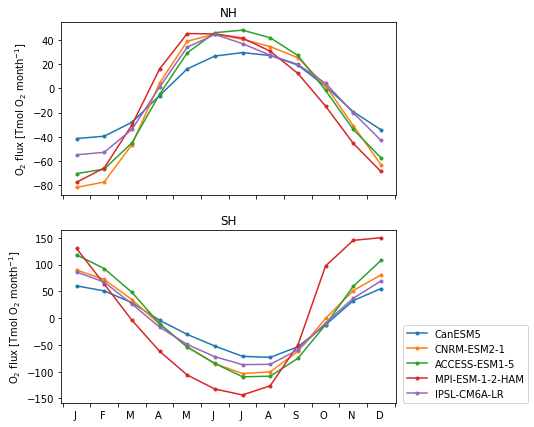

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7), facecolor='w')
    
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

for region, ax in zip(ds.region.values, axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds.fgo2.sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"O$_2$ flux [{ds.fgo2.attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));